In [77]:
import os, sys 
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import uniform_filter

import psutil
import torch
import torch.nn.functional as F

def memory_check():
    """
    Print the current memory usage.
    """
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
    print(f"Memory usage: {mem:.2f} MB")

def load_complex_data(file_path):
    """
    Load TIFF file containing real and imaginary parts in the last dimension (HxWx2) and combine them into complex data.

    Parameters:
        file_path (str): Path to the TIFF file.

    Returns:
        np.ndarray: Complex-valued 2D array.
    """
    data = tiff.imread(file_path)
    print(f"{file_path} loaded. shape: {data.shape}")

    if data.shape[-1] != 2:
        raise ValueError("Expected input data with last dimension as 2 for real and imaginary parts.")

    real_part = data[:, :, 0]
    imag_part = data[:, :, 1]

    return real_part + 1j * imag_part

def compute_pauli_vector(HH, HV, VH, VV):
    """
    Compute the Pauli vector representation using the provided polarimetric channels.

    Parameters:
        HH (np.ndarray): HH polarization complex data.
        HV (np.ndarray): HV polarization complex data.
        VH (np.ndarray): VH polarization complex data.
        VV (np.ndarray): VV polarization complex data.

    Returns:
        np.ndarray: 3xHxW Pauli vector.
    """
    # Pauli vector components
    pauli_1 = (HH + VV) / np.sqrt(2)
    pauli_2 = (HH - VV) / np.sqrt(2)
    pauli_3 = (HV + VH) / np.sqrt(2)

    print("Pauli vector computed")
    
    return np.stack([pauli_1, pauli_2, pauli_3], axis=0)

def compute_coherence_matrix(pauli_vector, window_size, block_size):
    """
    Compute the coherence matrix by processing block-by-block with neighborhood averaging.

    Parameters:
        pauli_vector (np.ndarray): 3xHxW Pauli vector.
        window_size (int): Size of the averaging window.
        block_size (int): Size of the processing blocks.

    Returns:
        np.ndarray: Coherence matrix with shape (3, 3, H, W).
    """
    H, W = pauli_vector.shape[1:]
    coherence_matrix = np.zeros((3, 3, H, W), dtype=np.complex64)
    pad_size = window_size // 2

    # Pad the Pauli vector to handle edge effects
    padded_pauli_vector = np.pad(pauli_vector, ((0, 0), (pad_size, pad_size), (pad_size, pad_size)), mode='reflect')

    for row_start in range(0, H, block_size):
        for col_start in range(0, W, block_size):
            row_end = min(row_start + block_size, H)
            col_end = min(col_start + block_size, W)

            # Add padding to the block for neighborhood filtering
            padded_row_start = row_start + pad_size
            padded_col_start = col_start + pad_size
            padded_row_end = row_end + pad_size
            padded_col_end = col_end + pad_size

            block = padded_pauli_vector[:, padded_row_start - pad_size:padded_row_end + pad_size,
                                        padded_col_start - pad_size:padded_col_end + pad_size]

            block_coherence = np.zeros((3, 3, block.shape[1] - 2 * pad_size, block.shape[2] - 2 * pad_size), dtype=np.complex64)

            # Compute block coherence matrix
            for i in range(3):
                for j in range(3):
                    block_coherence_full = block[i] * np.conj(block[j])

                    # Apply neighborhood averaging
                    block_coherence_avg = uniform_filter(block_coherence_full.real, size=window_size) + \
                                          1j * uniform_filter(block_coherence_full.imag, size=window_size)

                    # Trim the padding
                    block_coherence[i, j] = block_coherence_avg[pad_size:-pad_size, pad_size:-pad_size]

            # Assign back to the global coherence matrix
            coherence_matrix[:, :, row_start:row_end, col_start:col_end] = block_coherence

    print("Coherence_matrix computed")

    return coherence_matrix

def cloude_pottier_decomposition(pauli_vector, reference_vector, window_size=3, block_size=250):
    """
    Perform Cloude-Pottier decomposition to compute entropy, alpha angle, and classify land types.

    Parameters:
        pauli_vector (np.ndarray): 3xHxW Pauli vector.
        window_size (int): Size of the averaging window for the coherence matrix.
        block_size (int): Size of the processing blocks.

    Returns:
        tuple: Entropy (H), Alpha angle (alpha), and land type classification (Z).
    """
    H, W = pauli_vector.shape[1:]
    coherence_matrix = compute_coherence_matrix(pauli_vector, window_size, block_size)

    entropy = np.zeros((H, W))
    alpha = np.zeros((H, W))
    Z = np.zeros((H, W), dtype=np.uint8)

    # reference_vector = np.array([0, 0, 1], dtype=np.complex64)

    for i in range(H):
        print(f"Row: {i}")
        memory_check()
        for j in range(W):
            local_matrix = coherence_matrix[:, :, i, j]

            # Eigenvalue decomposition
            eigvals, eigvecs = np.linalg.eigh(local_matrix)
            eigvals = np.abs(eigvals)
            eigvals /= np.sum(eigvals)

            # Calculate entropy and alpha
            entropy[i, j] = -np.sum(eigvals * np.log(eigvals + 1e-10))

            # #Compute the mean alpha
            
            angles = np.arccos(np.clip(np.abs(np.dot(eigvecs.T, reference_vector)), 0, 1))
            angles_degrees = angles * (180 / np.pi)
            alpha[i, j] = np.sum(eigvals * angles_degrees)

            # angles = np.arccos(np.clip(np.abs(eigvecs[0, :]), 0, 1))  # Angles with reference [1, 0, 0] by default
            # angles_degrees = angles * (180 / np.pi)
            # alpha[i, j] = np.sum(eigvals * angles_degrees)

            # Land type classification
            if entropy[i, j] >= 0.9 and alpha[i, j] >= 55:
                Z[i, j] = 1  # Z1: Forest and canopy structures
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 42:
                Z[i, j] = 2  # Z2: Cloud
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 40:
                Z[i, j] = 3  # Z3: Not possible region
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 50:
                Z[i, j] = 4  # Z4: Forestry or double bounce
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 40:
                Z[i, j] = 5  # Z5: Vegetation
            elif entropy[i, j] >= 0.5 and alpha[i, j] < 40:
                Z[i, j] = 6  # Z6: Random surface propagation
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 48:
                Z[i, j] = 7  # Z7: Dihedral scatterer
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 42:
                Z[i, j] = 8  # Z8: Dipole
            elif entropy[i, j] < 0.5 and alpha[i, j] < 42:
                Z[i, j] = 9  # Z9: X-Bragg surface
            else:
                ValueError("alpha / entropy values are not valid")

    print("cloude_pottier_decomposition")

    return entropy, alpha, Z

def compute_coherence_matrix_torch(pauli_vector, window_size, block_size):
    """
    Compute the coherence matrix by processing block-by-block with neighborhood averaging using PyTorch on GPU.

    Parameters:
        pauli_vector (torch.Tensor): 3xHxW Pauli vector (input as PyTorch tensor).
        window_size (int): Size of the averaging window.
        block_size (int): Size of the processing blocks.

    Returns:
        torch.Tensor: Coherence matrix with shape (3, 3, H, W).
    """
    device = pauli_vector.device
    H, W = pauli_vector.shape[1:]
    pad_size = window_size // 2

    # Pad the Pauli vector to handle edge effects
    padded_pauli_vector = F.pad(pauli_vector, (pad_size, pad_size, pad_size, pad_size), mode='reflect')

    # Initialize coherence matrix
    coherence_matrix = torch.zeros((3, 3, H + 2 * pad_size, W + 2 * pad_size), dtype=torch.complex64, device=device)
    # Compute coherence matrix
    for i in range(3):
        for j in range(3):
            # Element-wise multiplication with conjugation
            coherence_element = padded_pauli_vector[i] * torch.conj(padded_pauli_vector[j])

            # Apply averaging filter (uniform filter equivalent)
            coherence_avg_real = F.avg_pool2d(coherence_element.real.unsqueeze(0), kernel_size=window_size, stride=1, padding=pad_size).squeeze(0)
            coherence_avg_imag = F.avg_pool2d(coherence_element.imag.unsqueeze(0), kernel_size=window_size, stride=1, padding=pad_size).squeeze(0)

            # Assign the result to the coherence matrix
            coherence_matrix[i, j] = coherence_avg_real + 1j * coherence_avg_imag
    
    coherence_matrix = coherence_matrix[:, :, pad_size:-pad_size, pad_size:-pad_size]

    # Ensure the matrix is Hermitian
    coherence_matrix = 0.5 * (coherence_matrix + coherence_matrix.conj().transpose(-2, -1))

    print(f"coherence_matrix_real shape: {coherence_matrix.shape}")
    print(f"Target size: {(H, W)}")

    # # Ensure the matrix is Hermitian
    # print(f"coherence_matrix shape before symmetrization: {coherence_matrix.shape}")
    # coherence_matrix = 0.5 * (coherence_matrix + coherence_matrix.conj().transpose(-2, -1))

    return coherence_matrix



def cloude_pottier_decomposition_torch(pauli_vector, reference_vector, window_size=5, block_size=10):
    """
    Perform Cloude-Pottier decomposition using PyTorch on GPU to compute entropy, alpha angle, and classify land types.

    Parameters:
        pauli_vector (torch.Tensor or np.ndarray): 3xHxW Pauli vector.
        reference_vector (torch.Tensor or np.ndarray): Reference vector.
        window_size (int): Size of the averaging window.
        block_size (int): Size of the processing blocks.

    Returns:
        tuple: Entropy (H), Alpha angle (alpha), and land type classification (Z).
    """
    H, W = pauli_vector.shape[1:]

    coherence_matrix = compute_coherence_matrix(pauli_vector, window_size, block_size)
    if isinstance(coherence_matrix, np.ndarray):
        coherence_matrix = torch.tensor(coherence_matrix, dtype=torch.complex64)
    if isinstance(reference_vector, np.ndarray):
        reference_vector = torch.tensor(reference_vector, dtype=torch.complex64)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"devise use: {device}")
    coherence_matrix = coherence_matrix.to(device)
    assert coherence_matrix.shape == (3, 3, H, W), f"coherence_matrix must have shape (3, 3, {H}, {W}), but got {coherence_matrix.shape}"

    reference_vector = reference_vector.to(device)

    coherence_matrix = torch.nan_to_num(coherence_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    # Reshape for parallel eigenvalue decomposition
    coherence_matrix_flat = coherence_matrix.contiguous().view(3, 3, -1).permute(2, 0, 1)  # Shape: (H*W, 3, 3)
    coherence_matrix_flat = coherence_matrix.contiguous().view(3, 3, -1).permute(2, 0, 1)
    assert coherence_matrix_flat.shape == (H * W, 3, 3), f"coherence_matrix_flat must have shape ({H * W}, 3, 3), but got {coherence_matrix_flat.shape}"
    
    # Check for NaN or Inf before eigendecomposition
    if torch.isnan(coherence_matrix_flat).any() or torch.isinf(coherence_matrix_flat).any():
        raise ValueError("coherence_matrix_flat contains NaN or Infinity values.")

    # Add small regularization to stabilize decomposition
    coherence_matrix_flat += torch.eye(3, dtype=coherence_matrix_flat.dtype, device=coherence_matrix_flat.device) * 1e-6

    # Debug problematic matrices
    for idx, matrix in enumerate(coherence_matrix_flat):
        if not torch.allclose(matrix, matrix.conj().transpose(-2, -1), atol=1e-6):
            print(f"Matrix at index {idx} is not Hermitian:")
            print(matrix)

    eigvals, eigvecs = torch.linalg.eigh(coherence_matrix_flat)  # Compute eigenvalues and eigenvectors

    eigvals = torch.abs(eigvals)
    eigvals_sum = eigvals.sum(dim=1, keepdim=True)
    eigvals /= eigvals_sum

    entropy_flat = -torch.sum(eigvals * torch.log(eigvals + 1e-10), dim=1)

    reference_vector = reference_vector.to(eigvecs.device)
    dot_products = torch.abs(torch.einsum('ijk,k->ij', eigvecs, reference_vector))
    angles = torch.acos(torch.clip(dot_products, 0, 1))
    angles_degrees = angles * (180 / torch.pi)
    alpha_flat = torch.sum(eigvals * angles_degrees, dim=1)

    entropy = entropy_flat.view(H, W)
    alpha = alpha_flat.view(H, W)

    Z = torch.zeros((H, W), dtype=torch.uint8, device=device)
    Z[(entropy >= 0.9) & (alpha >= 55)] = 1
    Z[(entropy >= 0.9) & (alpha >= 42)] = 2
    Z[(entropy >= 0.9) & (alpha >= 40)] = 3
    Z[(entropy >= 0.5) & (alpha >= 50)] = 4
    Z[(entropy >= 0.5) & (alpha >= 40)] = 5
    Z[(entropy >= 0.5) & (alpha < 40)] = 6
    Z[(entropy < 0.5) & (alpha >= 48)] = 7
    Z[(entropy < 0.5) & (alpha >= 42)] = 8
    Z[(entropy < 0.5) & (alpha < 42)] = 9

    return entropy, alpha, Z



def save_as_tiff(output_path, data):
    """
    Save a complex-valued 2D array as a multi-band TIFF file.

    Parameters:
        output_path (str): Path to save the TIFF file.
        data (np.ndarray): Data to save (supports real, complex, or multi-band).
        reference_file (str): Path to a reference TIFF file for shape and metadata.

    Returns:
        None
    """

    tiff.imwrite(output_path, data.astype(np.float32), dtype=np.float32)

def plot_intensity_and_angle(data, title_prefix):
    """
    Plot the intensity and angle of a complex dataset.

    Parameters:
        data (np.ndarray): Complex-valued 2D array.
        title_prefix (str): Prefix for the plot titles.

    Returns:
        None
    """
    intensity = np.abs(data)
    angle = np.angle(data)

    lower = np.percentile(intensity, 2)
    upper = np.percentile(intensity, 98)

    plt.figure(figsize=(12, 6))

    # Plot intensity
    plt.subplot(1, 2, 1)
    plt.imshow(intensity, cmap="gray", vmin=lower, vmax=upper)
    plt.title(f"{title_prefix} Intensity")
    plt.colorbar()

    # Plot angle
    plt.subplot(1, 2, 2)
    plt.imshow(angle, cmap="hsv")
    plt.title(f"{title_prefix} Angle")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


def plot_land_classification(Z):
    """
    Plot the land type classification with labeled regions and percentages.

    Parameters:
        Z (np.ndarray): Land type classification map.

    Returns:
        None
    """
    # Define a colormap and labels for the land types
    cmap = plt.cm.get_cmap('tab10', 9)
    labels = [
        "Z1: Forest and canopy structures",
        "Z2: Cloud",
        "Z3: Not possible region",
        "Z4: Forestry or double bounce",
        "Z5: Vegetation",
        "Z6: Random surface propagation",
        "Z7: Dihedral scatterer",
        "Z8: Dipole",
        "Z9: X-Bragg surface"
    ]

    # Calculate the percentage of each land type
    unique, counts = np.unique(Z, return_counts=True)
    total_pixels = Z.size
    percentages = {value: (count / total_pixels) * 100 for value, count in zip(unique, counts)}

    # Update labels to include percentages
    labels_with_percentages = [
        f"{label} ({percentages.get(i, 0):.2f}%)"
        for i, label in enumerate(labels, start=1)
    ]

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.imshow(Z, cmap=cmap, vmin=1, vmax=9)
    plt.colorbar(ticks=np.arange(1, 10), label="Land Type")

    # Add labels as text
    for i, label in enumerate(labels_with_percentages, start=1):
        plt.text(0, -i * 0.05, label, fontsize=10, transform=plt.gca().transAxes)

    plt.title("Land Type Classification")
    plt.axis("off")
    plt.show()

def perform_and_plot_land_classification(entropy, alpha, Z):
    """
    Plot the land type classification with labeled regions and a 2D density map of entropy and alpha.

    Parameters:
        entropy (np.ndarray): 2D array of entropy values.
        alpha (np.ndarray): 2D array of alpha values.

    Returns:
        None
    """
    # Ensure entropy and alpha have the same shape
    assert entropy.shape == alpha.shape, "Entropy and Alpha must have the same shape."
    
    H, W = entropy.shape

    # Define a colormap and labels for the land types
    cmap = plt.cm.get_cmap('tab10', 9)
    labels = [
        "Z1: Forest and canopy structures",
        "Z2: Cloud",
        "Z3: Not possible region",
        "Z4: Forestry or double bounce",
        "Z5: Vegetation",
        "Z6: Random surface propagation",
        "Z7: Dihedral scatterer",
        "Z8: Dipole",
        "Z9: X-Bragg surface"
    ]

    # Calculate the percentage of each land type
    unique, counts = np.unique(Z, return_counts=True)
    total_pixels = Z.size
    percentages = {value: (count / total_pixels) * 100 for value, count in zip(unique, counts)}

    # Update labels to include percentages
    labels_with_percentages = [
        f"{label} ({percentages.get(i, 0):.2f}%)"
        for i, label in enumerate(labels, start=1)
    ]

    # Create the plots
    plt.figure(figsize=(15, 7))

    # Plot 1: Land type classification
    plt.subplot(1, 2, 1)
    plt.imshow(Z, cmap=cmap, vmin=1, vmax=9)
    plt.colorbar(ticks=np.arange(1, 10), label="Land Type")
    for i, label in enumerate(labels_with_percentages, start=1):
        plt.text(0, -i * 0.05, label, fontsize=10, transform=plt.gca().transAxes)
    plt.title("Land Type Classification")
    plt.axis("off")

    # Plot 2: Logarithmic density map of entropy and alpha
    plt.subplot(1, 2, 2)

    # Définir une colormap personnalisée

        # Create a 2D histogram of entropy vs alpha
    density, xedges, yedges = np.histogram2d(
        entropy.ravel(), alpha.ravel(), bins=(50, 50)
    )
    
    # Apply log transformation to the density
    log_density = np.log1p(density)  # Use log1p to handle log(0)

    # Plot the density map
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    plt.imshow(
        log_density.T, origin="lower", extent=extent, cmap='hot', aspect="auto"
    )
    plt.colorbar(label="Log Density")
    plt.xlabel("Entropy")
    plt.ylabel("Alpha")
    plt.title("Logarithmic Density Map of Entropy and Alpha")

    plt.tight_layout()
    plt.show()


imagery_HH.tif loaded. shape: (14416, 2823, 2)
imagery_HV.tif loaded. shape: (14416, 2823, 2)
imagery_VH.tif loaded. shape: (14416, 2823, 2)
imagery_VV.tif loaded. shape: (14416, 2823, 2)
Pauli vector computed
Coherence_matrix computed
Row: 0
Memory usage: 4515.77 MB
Row: 1
Memory usage: 4515.77 MB
Row: 2
Memory usage: 4515.77 MB
Row: 3
Memory usage: 4515.77 MB
Row: 4
Memory usage: 4515.77 MB
Row: 5
Memory usage: 4515.77 MB
Row: 6
Memory usage: 4515.77 MB
Row: 7
Memory usage: 4515.77 MB
Row: 8
Memory usage: 4515.77 MB
Row: 9
Memory usage: 4516.03 MB
Row: 10
Memory usage: 4516.03 MB
Row: 11
Memory usage: 4516.03 MB
Row: 12
Memory usage: 4516.03 MB
Row: 13
Memory usage: 4516.03 MB
Row: 14
Memory usage: 4516.03 MB
Row: 15
Memory usage: 4516.03 MB
Row: 16
Memory usage: 4516.03 MB
Row: 17
Memory usage: 4516.03 MB
Row: 18
Memory usage: 4516.29 MB
Row: 19
Memory usage: 4516.29 MB
Row: 20
Memory usage: 4516.29 MB
Row: 21
Memory usage: 4516.29 MB
Row: 22
Memory usage: 4516.29 MB
Row: 23
Memory 

/tmp/ipykernel_513826/2662005587.py:433: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Accent', 9)


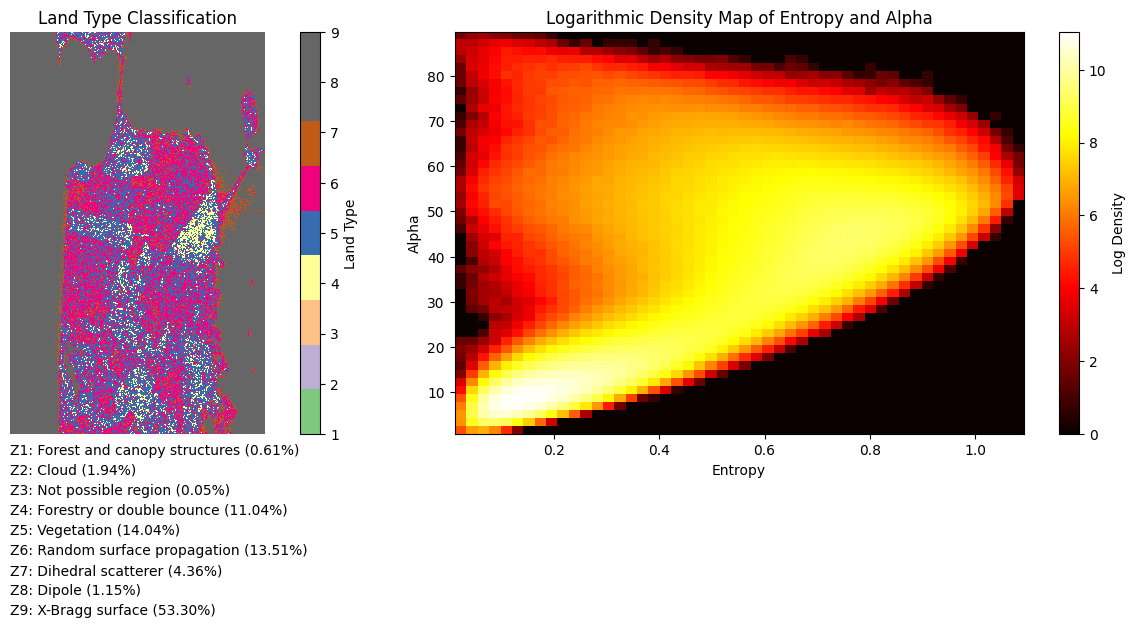

In [69]:
if __name__ == "__main__":
    # Load complex radar data
    base_dir = "/home/renaud/Polymetric_landcover/data/SAN_FRANCISCO_RS2"
    os.chdir(base_dir)
        
    S_HH = load_complex_data("imagery_HH.tif")
    # plot_intensity_and_angle(S_HH, "S_HH")

    xslice = slice(7000, 10000)  
    yslice = slice(400, 2300)

    window_size=3
    block_size=250

    S_HH = S_HH[xslice, yslice]
    S_HV = load_complex_data("imagery_HV.tif")
    S_HV = S_HV[xslice, yslice]
    S_VH = load_complex_data("imagery_VH.tif")
    S_VH = S_VH[xslice, yslice]

    S_VV = load_complex_data("imagery_VV.tif")
    S_VV = S_VV[xslice, yslice]

    pauli_vector = compute_pauli_vector(S_HH, S_HV, S_VH, S_VV)
    reference_vector = np.array([1, 0, 0], dtype=np.complex64)

    entropy, alpha, Z = cloude_pottier_decomposition(pauli_vector, reference_vector,  window_size, block_size)
    # plot_land_classification(Z)
    perform_and_plot_land_classification(entropy, alpha, Z)
    save_as_tiff("/home/renaud/Polymetric_landcover/output/subset_0_SAN_FRANCISCO_RS2_window_size_3_entropy.tif", entropy)
    save_as_tiff("/home/renaud/Polymetric_landcover/output/subset_0_SAN_FRANCISCO_RS2_window_size_3_alpha.tif", alpha)
    save_as_tiff("/home/renaud/Polymetric_landcover/output/subset_0_SAN_FRANCISCO_RS2_window_size_3_landtype.tif", Z)

    
    # reference_vector = np.array([0, 1, 0], dtype=np.complex64)
    # entropy, alpha, Z = cloude_pottier_decomposition(pauli_vector, reference_vector,  window_size=3, block_size=256)
    # plot_land_classification(Z)
    # reference_vector = np.array([0, 0, 1], dtype=np.complex64)
    # entropy, alpha, Z = cloude_pottier_decomposition(pauli_vector, reference_vector,  window_size=3, block_size=256)
    # plot_land_classification(Z)


/tmp/ipykernel_513826/159888270.py:433: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 9)


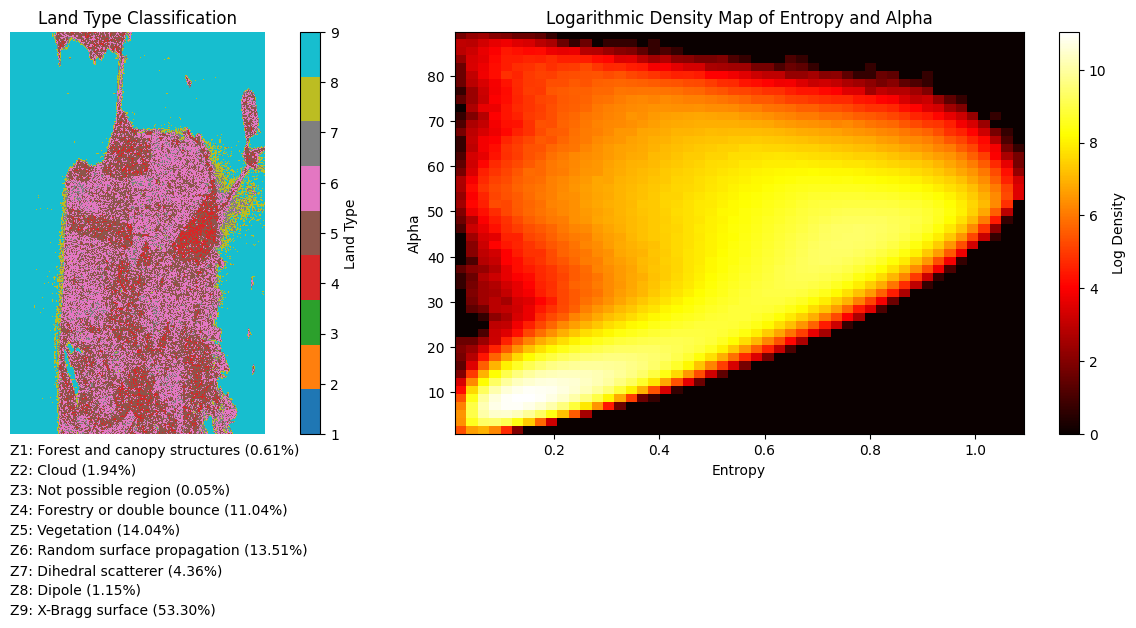

In [78]:
perform_and_plot_land_classification(entropy, alpha, Z)


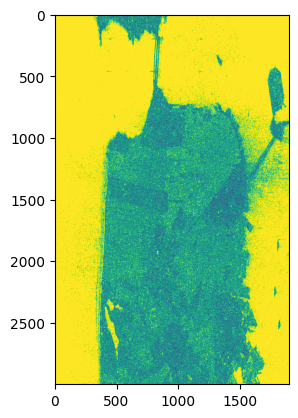

In [ ]:
# Compare entropy / alpha values with snap
base_dir = "/home/renaud/Data/polymetric_data/SAN_FRANCISCO_RS2/output"
snap_path = os.path.join(base_dir, "subset_0_SAN_FRANCISCO_RS2_landtype.tif")
data = tiff.imread(snap_path)
plt.imshow(data)